# **Introdução:**
Nesse caderno, será feito uma exploração e analise de dados de crédito, de clientes de um banco. Portanto, primeiro será feito uma exploração e tratamento dos dados, para entender o que há nessa base de crédito. Após isso, vamos analisar tendências e correlações entre as característricas dos clientes e os seus dados de crédito, e como um influencia o outro.

**Os dados:**
Os dados representam informações de clientes de um banco e contam com as seguintes colunas:

* idade = idade do cliente
* sexo = sexo do cliente (F ou M)
* dependentes = número de dependentes do cliente
* escolaridade = nível de escolaridade do clientes
* salario_anual = faixa salarial do cliente
* tipo_cartao = tipo de cartao do cliente
* qtd_produtos = quantidade de produtos comprados nos últimos 12 meses
* iteracoes_12m = quantidade de iterações/transacoes nos ultimos 12 meses
* meses_inativo_12m = quantidade de meses que o cliente ficou inativo
* limite_credito = limite de credito do cliente
* valor_transacoes_12m = valor das transações dos ultimos 12 meses
* qtd_transacoes_12m = quantidade de transacoes dos ultimos 12 meses

A tabela foi criada no AWS Athena, junto com o S3 Bucket, com uma versão com menos linhas da base de dados disponibilizada em: https://github.com/andre-marcos-perez/ebac-course-utils/tree/main/dataset

# **Exploração de dados:**
A primeira fase é entender oque há na nossa base, para isso vamos fazer algumas perguntas.

***Como são os dados?***

Query: SELECT * FROM credito LIMIT 10;


![](/kaggle/input/fotos/pytorch/default/1/CapturadeTela91.png)

***Quais os tipo de dados***

Query: DESCRIBE credito;

![](/kaggle/input/fotos/pytorch/default/1/92.png)



***Quantas linhas temos na nossa base de dados?***

Query: SELECT count(*) FROM credito

REPOSTA: 2564 linhas

***Quais são os tipos de cartão disponíveis no dataset?***

Query: SELECT DISTINCT tipo_cartao FROM credito

RESPOSTA: Silver, gold, platinum, blue.

# **Tratamento de dados**
Durante a exploração inicial, identificamos a presença de valores ausentes representados pela string 'na'.
Para garantir uma melhor qualidade na análise e apresentação dos dados, esses valores foram substituídos por uma categoria mais adequada.

 Query:
CREATE TABLE default.credito_limpo AS
SELECT
    idade,
    CASE WHEN sexo = 'na' THEN 'Não informado' ELSE sexo END AS sexo,
    dependentes,
    CASE WHEN escolaridade = 'na' THEN 'Não informado' ELSE escolaridade END AS escolaridade,
    CASE WHEN estado_civil = 'na' THEN 'Não informado' ELSE estado_civil END AS estado_civil,
    CASE WHEN salario_anual = 'na' THEN 'Não informado' ELSE salario_anual END AS salario_anual,
    CASE WHEN tipo_cartao = 'na' THEN 'Não informado' ELSE tipo_cartao END AS tipo_cartao,
    qtd_produtos,
    iteracoes_12m,
    meses_inativo_12m,
    limite_credito,
    valor_transacoes_12m,
    qtd_transacoes_12m
FROM default.credito;

# **Análise de dados**
Após explorarmos, vimos as informações que essa base disponibiliza, agora vamos analisar esses dados, para entender o que está acontecendo.


***Quais as características dos clientes que possuem os maiores creditos?***

Query: SELECT
    idade,
    sexo,
    escolaridade,
    estado_civil,
    tipo_cartao,
    limite_credito,
    salario_anual
FROM credito_limpo
ORDER BY limite_credito DESC
LIMIT 10;
![Minha imagem](https://github.com/WlandGLL/imagens/blob/main/59.png?raw=true)


Os clientes com os maiores limites, em sua maioria possuem uma renda superior a 80k e são predominantemente homens.

***Vamos dividir os clientes por faixa salarial e sexo***

Query: SELECT
    salario_anual,
    sexo,
    COUNT(*) AS quantidade
FROM credito_limpo
GROUP BY salario_anual, sexo
ORDER BY
    CASE salario_anual
        WHEN 'menos que $40K' THEN 1
        WHEN '$40K - $60K' THEN 2
        WHEN '$60K - $80K' THEN 3
        WHEN '$80K - $120K' THEN 4
        WHEN '$120K +' THEN 5
    END,
    sexo;
![Minha imagem](https://github.com/WlandGLL/imagens/blob/main/54.png?raw=true)
)

A maioria dos cliente dessa base recebe mais que 40k, além do mais, não há nenhuma mulher nessa base que recebe mais que 60k. Há também 235 clientes sem o valor do salario informado, e a maioria são mulheres. Outra analise importante, a maioria dos clientes são homens.

***O limite de crédito varia com a renda salarial?***

Query:SELECT
    salario_anual,
    AVG(limite_credito) AS media_limite
FROM credito_limpo
GROUP BY salario_anual
ORDER BY
    CASE salario_anual
        WHEN 'menos que $40K' THEN 1
        WHEN '$40K - $60K' THEN 2
        WHEN '$60K - $80K' THEN 3
        WHEN '$80K - $120K' THEN 4
        WHEN '$120K +' THEN 5
    END;
![Minha imagem](https://github.com/WlandGLL/imagens/blob/main/56.png?raw=true)
)

analisando os valores, percebe-se que, quem tem um salario maior, têm um limite maior

***O limite de crédtio e as transacoes variam com o estado civil?***

Query: SELECT
    estado_civil,
    AVG(valor_transacoes_12m) AS media_transacoes,
    AVG(limite_credito) AS media_limite
FROM default.credito_limpo
GROUP BY estado_civil
ORDER BY estado_civil;
![Minha imagem](https://github.com/WlandGLL/imagens/blob/main/57.png?raw=true)


os clientes casados movimentam menos dinheiro e tem um limite menor comparado com os divorciados e os solteiros, ambos os dois possuem uma média bem simlar.

***O limite de credito e as transações variam de acordo com a escolaridade?***

Query:SELECT
   escolaridade,
   AVG(limite_credito) AS media_limite,
   MAX(limite_credito) AS max_limite,
   MIN(limite_credito) AS min_limite
FROM credito_limpo
GROUP BY escolaridade
ORDER BY media_limite DESC;
![Minha imagem](https://github.com/WlandGLL/imagens/blob/main/58.png?raw=true)


A escolaridade influencia pouco os valores do limite de crédito.


***A idade influência no limite de crédito?***

Para descobrir isso, vamos gerar um gráfico que mostra a média do limite de crédito por idade.

In [4]:
import pandas as pd

In [5]:
df = pd.read_csv("./credito.csv", sep=",")
df.head()

,idade,sexo,dependentes,escolaridade,estado_civil,salario_anual,tipo_cartao,qtd_produtos,iteracoes_12m,meses_inativo_12m,limite_credito,valor_transacoes_12m,qtd_transacoes_12m
0,45,M,3,ensino medio,casado,$60K - $80K,blue,5,3,1,12691.51,1144.90,42
1,49,F,5,mestrado,solteiro,menos que $40K,blue,6,2,1,8256.96,1291.45,33
2,51,M,3,mestrado,casado,$80K - $120K,blue,4,0,1,3418.56,1887.72,20
3,40,F,4,ensino medio,Não informado,menos que $40K,blue,3,1,4,3313.03,1171.56,20
4,40,M,3,sem educacao formal,casado,$60K - $80K,blue,5,0,1,4716.22,816.08,28


In [11]:
import matplotlib.pyplot as plt


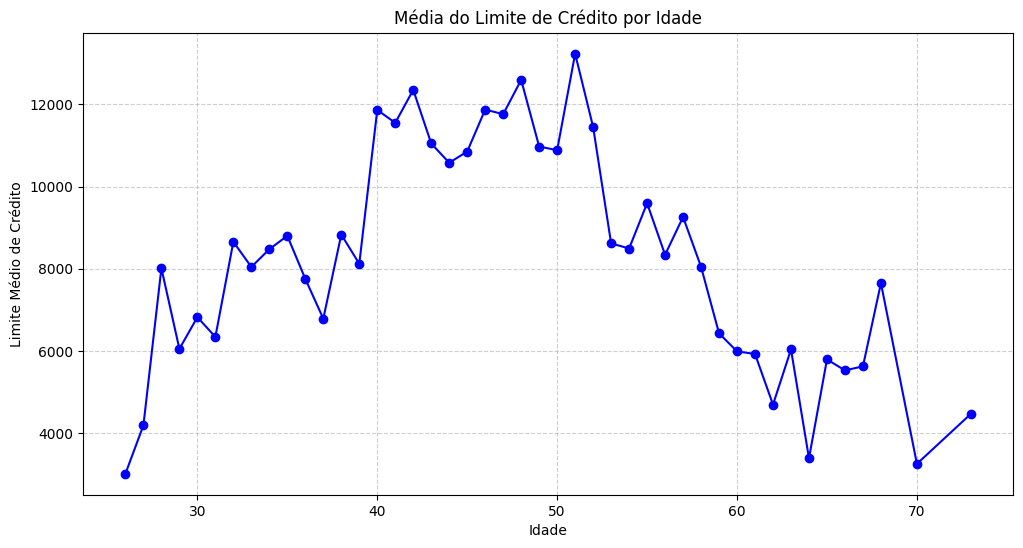

In [12]:
# Média do limite de crédito por idade
media_por_idade = df.groupby('idade')['limite_credito'].mean()

plt.figure(figsize=(12,6))
plt.plot(media_por_idade.index, media_por_idade.values, marker='o', linestyle='-', color='blue')

plt.title('Média do Limite de Crédito por Idade')
plt.xlabel('Idade')
plt.ylabel('Limite Médio de Crédito')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


Analisando o gráfico, nota-se que, os maiores limites estão entre clientes de 40 a 50 anos.

# **Conclusão**

Essas foram alguns insights interessantes:

* a maior parte dos clientes possui renda maior que 40K.
* a maior parte dos clientes é masculino!.
* a escolaridade não parece influenciar no limite.
* os clientes com maiores limites são em sua maioria homens e possuem maiores rendas salariais.
* a faixa salarial impacta diretamente no limite de crédito.
* nao existem clientes com salário anual acima de 60K do sexo feminino.
* clientes com idades entre 40 e 50 anos, possuem limites maiores.
* clientes divorciados e solteiros possuem limites maiores e movimentam mais dinheiro que clientes casados.
* a escolaridade parece influenciar pouco no limite de crédito